In [2]:
import tensorflow as tf

C:\Users\Nadezhda\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
import IPython.display as ipd
#Для интереса воспроизведем один из файлов
ipd.Audio("./data_v_7_stc/audio/background_0009.wav")

In [11]:
# Будем использовать библиотеку librose
import librosa

In [12]:
data, sampling_rate = librosa.load('./data_v_7_stc/audio/background_0009.wav')

In [13]:
data

array([ 5.7113942e-07, -9.6981796e-07,  4.9557104e-07, ...,
       -3.8098538e-04, -2.0652685e-04,  0.0000000e+00], dtype=float32)

In [14]:
sampling_rate

22050

In [80]:
% pylab inline
import os
import pandas as pd
import glob
import librosa.display
import numpy as np

Populating the interactive namespace from numpy and matplotlib


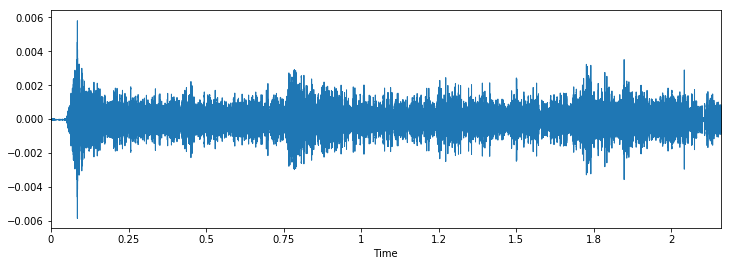

In [21]:
# Посмотрим как выглядит запись
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

In [47]:
# Из файла meta.txt получим название файла и метку для него
data = pd.read_csv('./data_v_7_stc/meta/meta.txt', sep='	', header=None)
data.columns = ['sound', '1', '2', '3', 'label']

In [48]:
data

,sound,1,2,3,label
0,background_0001.wav,office,0,9.458500,background
1,background_0001_time_stretch_0.wav,office,0,9.989070,background
2,background_0001_time_stretch_1.wav,office,0,9.879410,background
3,background_0001_time_stretch_10.wav,office,0,11.156553,background
4,background_0001_time_stretch_11.wav,office,0,13.261587,background
5,background_0001_time_stretch_12.wav,office,0,9.186440,background
6,background_0001_time_stretch_13.wav,office,0,8.117642,background
7,background_0001_time_stretch_2.wav,office,0,12.337098,background
8,background_0001_time_stretch_3.wav,office,0,12.455147,background
9,background_0001_time_stretch_4.wav,office,0,7.765306,background


In [49]:
#Удалим лишние колонки
data = data.drop(['1', '2', '3'], axis=1)
data

,sound,label
0,background_0001.wav,background
1,background_0001_time_stretch_0.wav,background
2,background_0001_time_stretch_1.wav,background
3,background_0001_time_stretch_10.wav,background
4,background_0001_time_stretch_11.wav,background
5,background_0001_time_stretch_12.wav,background
6,background_0001_time_stretch_13.wav,background
7,background_0001_time_stretch_2.wav,background
8,background_0001_time_stretch_3.wav,background
9,background_0001_time_stretch_4.wav,background


In [74]:
# Будем использовать эту функцию для загрузки файлов и нахождения в них особенностей с помощью librosa.feature.mfcc
def parser(row):
    file_name = os.path.join('./data_v_7_stc/audio/', row.sound)
    # Проверка, что удалось открыть текущий файл
    try:
        # Используем kaiser_fast для более быстрого выделения особенностей
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None, None
    
    feature = mfccs
    label = row.label

    return [feature, label]

temp = data.apply(parser, axis=1)
temp.columns = ['feature', 'label']

In [75]:
temp

,feature,label
0,"[-745.6983883064427, 103.25187632275701, -41.2...",background
1,"[-733.0405982930499, 52.84822906427858, -7.643...",background
2,"[-732.0074936403333, 53.36846042015167, -7.529...",background
3,"[-736.3998798767176, 52.36939970049935, -6.885...",background
4,"[-738.3703046750516, 52.70442375836594, -5.679...",background
5,"[-730.1097524006257, 54.856824313622326, -6.79...",background
6,"[-736.3152135969676, 55.50721333672005, -5.328...",background
7,"[-737.5815738697584, 52.566100488072024, -6.35...",background
8,"[-737.7744272752535, 52.61747314951953, -6.069...",background
9,"[-737.4292206220329, 55.40196169780292, -4.980...",background


In [81]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from sklearn import metrics 

In [99]:
X = np.array(temp.feature.tolist())
y = np.array(temp.label.tolist())
y

array(['background', 'background', 'background', ..., 'tool', 'tool',
       'tool'], dtype='<U13')

In [100]:
# Перекодируем метки в числа
lb = LabelEncoder()
y = np_utils.to_categorical(lb.fit_transform(y))
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [84]:
num_labels = y.shape[1]
filter_size = 2

# Построим модель
model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# Обучим модель
model.fit(X, y, batch_size=32, epochs=40,  validation_split=0.1)#validation_data=(x, y))

Train on 10176 samples, validate on 1131 samples
Epoch 1/40
10176/10176 [==============================] - 4s 426us/step - loss: 9.4755 - acc: 0.3999 - val_loss: 6.2588 - val_acc: 0.5818
Epoch 2/40
10176/10176 [==============================] - 2s 210us/step - loss: 8.6493 - acc: 0.4573 - val_loss: 5.9057 - val_acc: 0.6057
Epoch 3/40
10176/10176 [==============================] - 2s 211us/step - loss: 8.5888 - acc: 0.4634 - val_loss: 7.1090 - val_acc: 0.5411
Epoch 4/40
10176/10176 [==============================] - 2s 204us/step - loss: 8.5372 - acc: 0.4673 - val_loss: 8.5357 - val_acc: 0.4456
Epoch 5/40
10176/10176 [==============================] - 1s 127us/step - loss: 8.5167 - acc: 0.4667 - val_loss: 9.3743 - val_acc: 0.3749
Epoch 6/40
10176/10176 [==============================] - 1s 124us/step - loss: 8.4023 - acc: 0.4726 - val_loss: 9.5288 - val_acc: 0.3749
Epoch 7/40
10176/10176 [==============================] - 1s 122us/step - loss: 8.2567 - acc: 0.4810 - val_loss: 4.3876 - v

In [89]:
# Тестирование
sounds = os.listdir('./data_v_7_stc/test')
sounds

['background_0001.wav',
 'background_0004.wav',
 'background_0009.wav',
 'background_0012.wav',
 'background_0016.wav',
 'background_0018.wav',
 'background_0022.wav',
 'background_0028.wav',
 'background_0031.wav',
 'background_0036.wav',
 'background_0039.wav',
 'background_0043.wav',
 'background_0046.wav',
 'background_0049.wav',
 'background_0051.wav',
 'background_0056.wav',
 'background_0060.wav',
 'background_0063.wav',
 'background_0068.wav',
 'background_0070.wav',
 'background_0074.wav',
 'background_0077.wav',
 'background_0078.wav',
 'background_0080.wav',
 'background_0085.wav',
 'background_0089.wav',
 'background_0092.wav',
 'background_t_0001.wav',
 'background_t_0002.wav',
 'background_t_0003.wav',
 'background_t_0004.wav',
 'background_t_0005.wav',
 'background_t_0006.wav',
 'background_t_0007.wav',
 'background_t_0008.wav',
 'background_t_0009.wav',
 'background_t_0010.wav',
 'background_t_0011.wav',
 'background_t_0012.wav',
 'background_t_0013.wav',
 'background_t

In [92]:
test_data = pd.DataFrame(sounds)
test_data.columns = ['sound']
test_data

,sound
0,background_0001.wav
1,background_0004.wav
2,background_0009.wav
3,background_0012.wav
4,background_0016.wav
5,background_0018.wav
6,background_0022.wav
7,background_0028.wav
8,background_0031.wav
9,background_0036.wav


In [93]:
# Аналог функции parser для тестовых данных(нет меток)
def parser_for_test_data(row):
    file_name = os.path.join('./data_v_7_stc/test/', row.sound)
    try:
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None
    
    feature = mfccs
    
    return [feature]

temp_test = test_data.apply(parser_for_test_data, axis=1)
temp_test.columns = ['feature']

In [94]:
temp_test

,feature
0,"[-630.5837928121166, 161.75367050947676, -47.2..."
1,"[-627.4627728789545, 162.36459466730818, -46.0..."
2,"[-631.6345319062981, 159.21671343719825, -50.2..."
3,"[-633.136520871344, 160.0025063551649, -48.929..."
4,"[-628.7315465435945, 154.43949059910355, -46.7..."
5,"[-618.7000670104849, 142.25665420250007, -38.5..."
6,"[-636.522888442038, 158.39457388551415, -48.22..."
7,"[-703.2657756906833, 119.3656759902136, -55.85..."
8,"[-697.4483410814449, 110.1837118897514, -63.84..."
9,"[-707.8154620357876, 113.87267192949538, -58.0..."


In [95]:
X_test = np.array(temp_test.feature.tolist())

In [122]:
# Посмотрим, с какой вероятностью каждый файл принадлежит соответсвующему классу
predict_score = model.predict(X_test)
predict_score

array([[4.5410007e-01, 3.3337562e-03, 4.0766053e-02, ..., 5.0168564e-03,
        2.2048315e-02, 9.1894688e-03],
       [6.0279685e-01, 7.5543835e-04, 2.0762801e-02, ..., 3.0524028e-03,
        1.6204448e-02, 4.8026168e-03],
       [3.9435005e-01, 5.0329352e-03, 4.9918324e-02, ..., 5.4094316e-03,
        2.3889188e-02, 1.0208328e-02],
       ...,
       [9.6994802e-02, 3.1398490e-02, 1.8099878e-02, ..., 2.1780701e-02,
        6.7464873e-02, 2.0458959e-02],
       [1.3303847e-07, 6.5861329e-08, 3.9773770e-03, ..., 5.1813291e-05,
        4.9430788e-01, 4.9963310e-01],
       [3.0456280e-04, 5.6301764e-07, 7.4775792e-03, ..., 2.3175505e-04,
        9.2783362e-01, 5.4060731e-02]], dtype=float32)

In [114]:
# Предсказанные классы для каждого файла
pred = model.predict_classes(X_test)

In [115]:
pred

array([0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 6, 4, 4, 4, 4, 4, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 3, 1, 3, 2, 2, 2, 2, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 2,
       2, 2, 2, 2, 6, 4, 6, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4,
       0, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 6, 4, 4, 4, 4, 4,
       6, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 4, 4, 4, 6, 4, 4, 6, 6, 4, 4, 2,
       6, 6, 4, 4, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5,
       2, 5, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [123]:
encoded_pred = pred

In [124]:
# Перекодируем числовые значения меток в их изначальные названия
decoded_pred = lb.inverse_transform(pred)

C:\Users\Nadezhda\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [125]:
decoded_pred

array(['background', 'background', 'background', 'background',
       'background', 'background', 'background', 'keyboard', 'keyboard',
       'keyboard', 'keyboard', 'keyboard', 'door', 'door', 'door', 'door',
       'background', 'background', 'door', 'background', 'door',
       'background', 'background', 'background', 'background',
       'background', 'background', 'background', 'background',
       'background', 'knocking_door', 'background', 'knocking_door',
       'background', 'speech', 'knocking_door', 'knocking_door',
       'knocking_door', 'knocking_door', 'knocking_door', 'door', 'bags',
       'bags', 'bags', 'bags', 'bags', 'bags', 'bags', 'bags', 'bags',
       'bags', 'bags', 'bags', 'bags', 'bags', 'bags', 'bags', 'bags',
       'bags', 'bags', 'bags', 'bags', 'bags', 'bags', 'bags', 'bags',
       'bags', 'bags', 'keyboard', 'bags', 'keyboard', 'door', 'door',
       'door', 'door', 'ring', 'ring', 'ring', 'bags', 'bags', 'bags',
       'bags', 'bags', 'bags', 'bag

In [145]:
#Запишем полученные результаты в файл result.txt
df = pd.DataFrame({
    'FileName': sounds
})
df['Score'] = np.max(predict_score, axis=1)
df['Class'] =  decoded_pred
df

,FileName,Score,Class
0,background_0001.wav,0.454100,background
1,background_0004.wav,0.602797,background
2,background_0009.wav,0.394350,background
3,background_0012.wav,0.386738,background
4,background_0016.wav,0.397242,background
5,background_0018.wav,0.681245,background
6,background_0022.wav,0.431715,background
7,background_0028.wav,0.469733,keyboard
8,background_0031.wav,0.483411,keyboard
9,background_0036.wav,0.455409,keyboard


In [146]:
df.to_csv(r'./result.txt', header=None, index=None, sep=' ', mode='a')

In [126]:
#Посчитаем точность на открытых данных, таких 473 записи
y_pred = encoded_pred[:473]
y_pred

array([0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 6, 4, 4, 4, 4, 4, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 3, 1, 3, 2, 2, 2, 2, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 2,
       2, 2, 2, 2, 6, 4, 6, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4,
       0, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 4, 6, 4, 4, 4, 4, 4,
       6, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 4, 4, 4, 6, 4, 4, 6, 6, 4, 4, 2,
       6, 6, 4, 4, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5,
       2, 5, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [147]:
# Получим истинное значение на открытых данных (вытащили из названия)
encod = {'back' : 0, 'bags' : 1, 'door' : 2, 'keyb' : 3,  'knoc' : 4, 'ring' : 5, 'spee' : 6, 'tool' : 7 }
check = sounds[:473]
y_true = []
for sound in check:
    y_true.append(encod[sound[:4]])
print(y_true)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 

In [148]:
# И посчитаем точность предсказания
right_number = 0
for i in range(0, 473):
    if (y_pred[i] == y_true[i]):
        right_number += 1
score = right_number/473
score

0.8181818181818182

В принципе, скор неплох :)